In [19]:
from pathlib import Path
import h5py
import hdf5plugin
import sys


import cv2
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from rectify_event_depth import Pixel_Projector
import pandas as pd


In [4]:
dsec_dir = "data/NSEK"

In [5]:
# Ensure DSEC directory is valid
dsec_dir = Path(dsec_dir)
assert dsec_dir.is_dir(), f"Invalid DSEC directory: {dsec_dir}"

In [6]:
def disp_img_to_rgb_img_NSEK(disp_array: np.ndarray):
    disp_pixels = np.argwhere(disp_array > 0)
    u_indices = disp_pixels[:, 1]
    v_indices = disp_pixels[:, 0]
    disp = disp_array[v_indices, u_indices]*256
    max_disp = 1500

    norm = mpl.colors.Normalize(vmin=0, vmax=max_disp, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap='inferno')

    disp_color = mapper.to_rgba(disp)[..., :3]
    output_image = np.zeros((disp_array.shape[0], disp_array.shape[1], 3))
    output_image[v_indices, u_indices, :] = disp_color
    output_image = (255 * output_image).astype("uint8")
    output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)
    return output_image 
 

In [7]:
def get_disp_overlay(image_1c, disp_rgb_image, height, width):
    image = np.repeat(image_1c[..., np.newaxis], 3, axis=2)
    overlay = cv2.addWeighted(image, 0.1, disp_rgb_image, 0.9, 0)
    return overlay
    
def show_disp_overlay_ipynb(image_1c, disp_rgb_image, height, width):
    overlay = get_disp_overlay(image_1c, disp_rgb_image, height, width)
    return overlay

In [49]:
for folder in Path("output/visualize/pred/test").iterdir():
    print(folder.name)

K_EWI_cereal_bowl
K_EWI_wash_dish_2
K_Alejandro_fry_egg
K_Alejandro_fry_pepper
K_SXW_coffee
K_EWI_cut_bread
K_SXW_cut_bread
K_SXW_tea_2
K_SGHC_coffee
K_SGHC_vege_salad


In [50]:
test_kitchen_activity = "K_SXW_coffee" 
test_folder = Path("output/visualize/pred/test") / test_kitchen_activity
gt_folder = Path("data/NSEK/test") / test_kitchen_activity / "disparity" / "event"
files = list(test_folder.glob("*.png"))
gt_files = list(gt_folder.glob("*.png"))
# assert all files in files are in gt_files
assert all([file.name in [gt_file.name for gt_file in gt_files] for file in files])
activity = Path("data/NSEK/test") / test_kitchen_activity
print(f"Processing activity: {activity.name}")
splits = activity.name.split("_")
kitchen = splits[0] + "_" + splits[1]
activity_name = "_".join(splits[2:])
print(f"Kitchen: {kitchen}, Activity Name: {activity_name}")
csv_file = activity / (activity.name + ".csv")
df = pd.read_csv(csv_file)
assert df.shape[0] > 0, f"CSV file {csv_file} is empty or does not exist"

camera_type = {
    "K_SXW": "435",
    "K_EWI": "455",
    "K_Alejandro": "455",
    "K_SGHC": "435",
}
assert kitchen in camera_type, f"Kitchen {kitchen} not found in camera_type mapping"
calibration_path = (
     Path("data")
    / "Calibration"
    / "calibration_results"
    / ("calibration_with_" + camera_type[kitchen])
)
reconstructed_data_path = (
     Path("data")
    / "Reconstruction"
    / kitchen
    / activity_name
)
assert (
    calibration_path.exists()
), f"Calibration path {calibration_path} does not exist"
assert (
    reconstructed_data_path.exists()
), f"Reconstructed data path {reconstructed_data_path} does not exist"

projector = Pixel_Projector(
    calibration_path=calibration_path,
    data_path=reconstructed_data_path,
)


Processing activity: K_SXW_coffee
Kitchen: K_SXW, Activity Name: coffee


RMSE: 164.46 mm


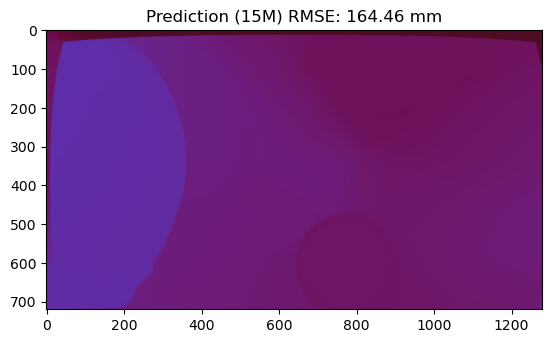

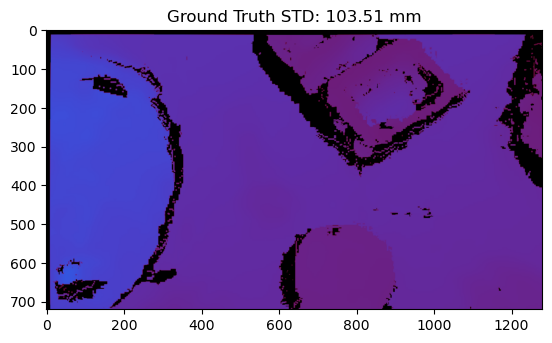

In [58]:
idx = np.random.randint(0, len(files))
img = cv2.imread(str(files[idx]), -1)
gt_img = cv2.imread(str(gt_folder / files[idx].name), -1)
out = disp_img_to_rgb_img_NSEK(img.astype(np.float32)/256)
gt_out = disp_img_to_rgb_img_NSEK(gt_img.astype(np.float32)/256)

# Compute RMSE between prediction and ground truth
valid_indices = gt_img > 0
img = img[valid_indices]
gt_img = gt_img[valid_indices]

rmse = np.sqrt(np.mean((img - gt_img)**2))
print(f"RMSE: {rmse:.2f} mm")

plt.imshow(out)
plt.title("Prediction (15M) RMSE: {:.2f} mm".format(rmse))
plt.show()
plt.imshow(gt_out)
plt.title("Ground Truth STD: {:.2f} mm".format(gt_img.std()))
plt.show()
timestamp = np.int64(files[idx].stem)*1e6

Processing timestamp: 1705351090.409087, idx: 2062, Ground truth file data/NSEK/test/K_SXW_coffee/disparity/event/002062.png


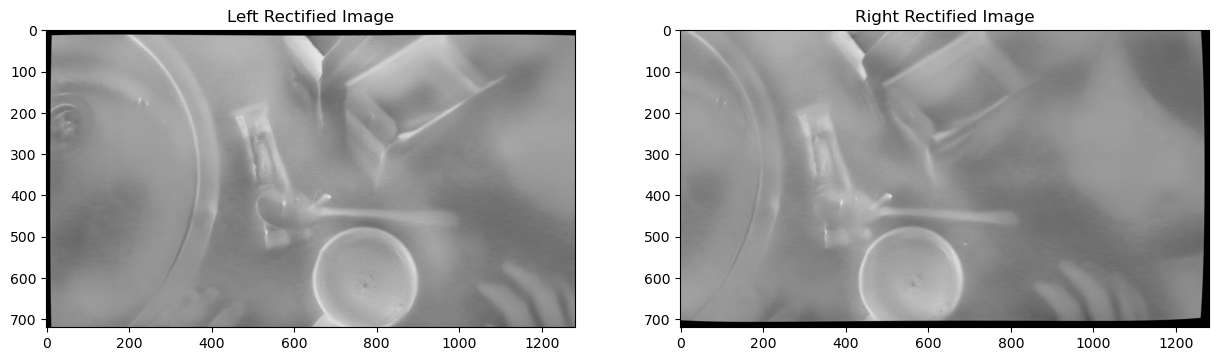

In [59]:
file_number = int(files[idx].name[:-4])
timestamp = float(df["# timestamp_us"][df["file_index"] ==  file_number].item()) * 1e-6
print(f"Processing timestamp: {timestamp}, idx: {file_number}", flush=True, end=", ")
print(f"Ground truth file", str(gt_folder / files[idx].name))
left_rectified, right_rectified = projector.rectify(timestamp)

# Display the left and right rectified images
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(left_rectified, cmap='gray')
plt.title("Left Rectified Image")
plt.subplot(1, 2, 2)
plt.imshow(right_rectified, cmap='gray')
plt.title("Right Rectified Image")
plt.show()

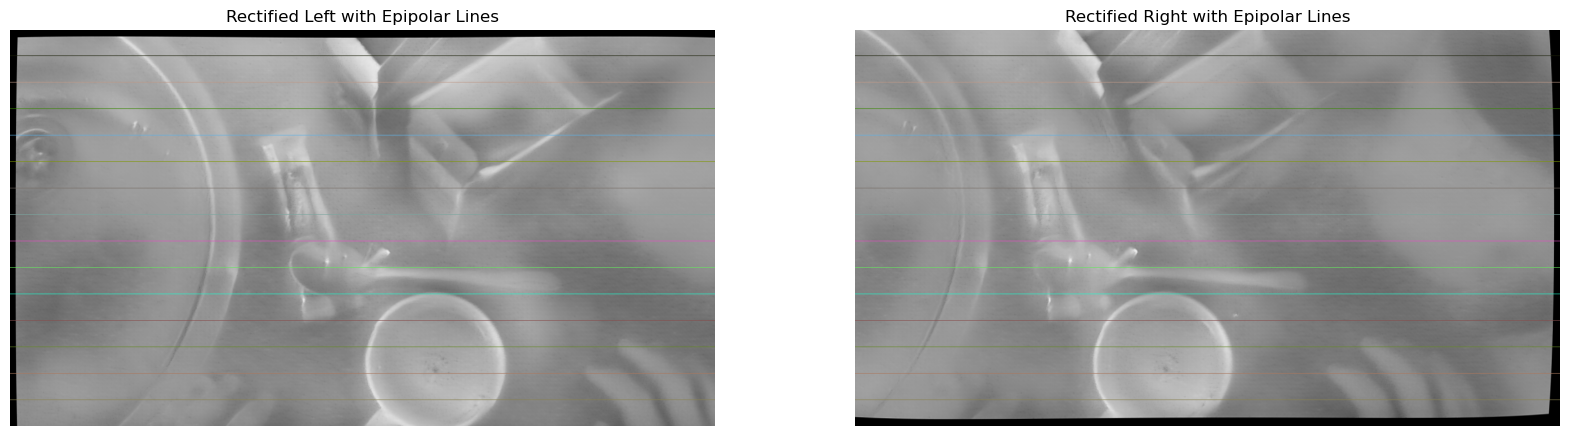

In [60]:
# Display the rectified left and right images with epipolar lines

img1_color = left_rectified
img2_color = right_rectified
num_lines=15
h, w = img1_color.shape[:2]
step = h // num_lines


for i in range(step, h, step):
       color = tuple(np.random.randint(0, 255, 3).tolist())
       cv2.line(img1_color, (0, i), (w, i), color, 1)
       cv2.line(img2_color, (0, i), (w, i), color, 1)


# Show result
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Rectified Left with Epipolar Lines")
plt.imshow(img1_color[..., ::-1])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Rectified Right with Epipolar Lines")
plt.imshow(img2_color[..., ::-1])
plt.axis('off')
plt.show()



In [62]:
# save the rectified images
cv2.imwrite("left_rectified.png", left_rectified)
cv2.imwrite("right_rectified.png", right_rectified)

# Run this code in apptainer 
"""
cd /tudelft.net/staff-umbrella/NSEK/Model_zoo/Depth_estimation/FoundationStereo/
apptainer exec --nv --pwd $(pwd -P) --no-home --bind /tmp/home/:/home/nfs FoundationStereo.sif python scripts/run_demo.py --left_file left_rectified.png --right_file right_rectified.png --ckpt_dir pretrained_models/23-51-11/model_best_bp2.pth --out_dir ./FS_output/

or

python scripts/run_demo.py --left_file left_rectified.png --right_file right_rectified.png --ckpt_dir ./pretrained_models/23-51-11/model_best_bp2.pth --out_dir ./FS_output/
"""


'\ncd /tudelft.net/staff-umbrella/NSEK/Model_zoo/Depth_estimation/FoundationStereo/\napptainer exec --nv --pwd $(pwd -P) --no-home --bind /tmp/home/:/home/nfs FoundationStereo.sif python scripts/run_demo.py --left_file left_rectified.png --right_file right_rectified.png --ckpt_dir pretrained_models/23-51-11/model_best_bp2.pth --out_dir ./FS_output/\n\nor\n\npython scripts/run_demo.py --left_file left_rectified.png --right_file right_rectified.png --ckpt_dir ./pretrained_models/23-51-11/model_best_bp2.pth --out_dir ./FS_output/\n'

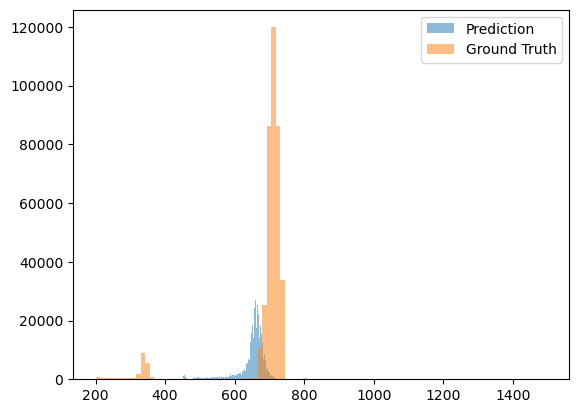

In [27]:
# plot the histogram of the disparity values in the prediction and ground truth images in one figure
plt.hist(img, bins=100, alpha=0.5, label="Prediction")
plt.hist(gt_img, bins=100, alpha=0.5, label="Ground Truth")
plt.legend()
plt.show()

In [11]:
# compute the mean of the disparity values for all the files in the test folder
disparity_files = Path("data/DSEC/train/interlaken_00_c/disparity/event").glob('*.png')

disparity_mean = []
for file in disparity_files:
    img = cv2.imread(str(file), -1)
    disparity_mean.append(img[img > 0].mean())

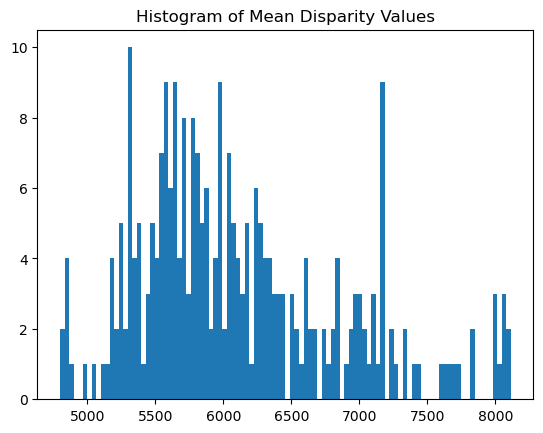

Mean disparity value: 6113.40
STD disparity value: 747.32
Mean disparity value/256: 23.88
STD disparity value/256: 2.92


In [12]:
plt.hist(disparity_mean, bins=100)
plt.title("Histogram of Mean Disparity Values")
plt.show()
print(f"Mean disparity value: {np.mean(disparity_mean):.2f}")
print(f"STD disparity value: {np.std(disparity_mean):.2f}")
print(f"Mean disparity value/256: {np.mean(disparity_mean)/256:.2f}")
print(f"STD disparity value/256: {np.std(disparity_mean)/256:.2f}")

In [13]:
# compute the mean of the disparity values for all the files in the test folder
disparity_files = Path("data/NSEK/test/K_SXW_coffee/disparity/event").glob('*.png')

depth_mean = []
for file in disparity_files:
    img = cv2.imread(str(file), -1)
    depth_mean.append(img[img > 0].mean())


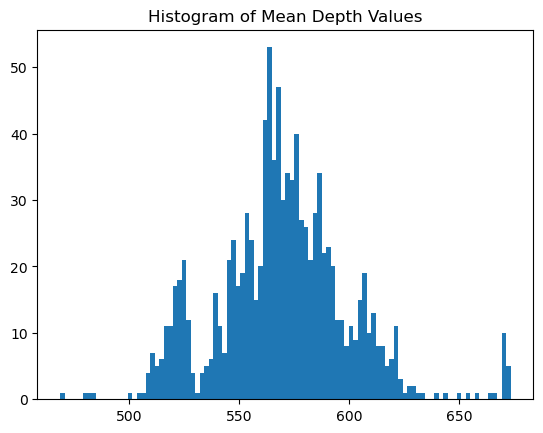

Mean depth value: 569.92
STD depth value: 30.14
Mean depth value/256: 2.23
STD depth value/256: 0.12


In [14]:
plt.hist(depth_mean, bins=100)
plt.title("Histogram of Mean Depth Values")
plt.show()
print(f"Mean depth value: {np.mean(depth_mean):.2f}")
print(f"STD depth value: {np.std(depth_mean):.2f}")
print(f"Mean depth value/256: {np.mean(depth_mean)/256:.2f}")
print(f"STD depth value/256: {np.std(depth_mean)/256:.2f}")
